In [136]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500000

In [137]:
data = pd.read_csv('sorted_coded_data.csv')

#  Sleeptime distribution

I start by calculating the sleep time for each app. Here it corresponds to the time from when the user closed the last app, to he/she opened the current app.

In [138]:
user_groups=data.groupby('user_id')

In [139]:
data['sleep_time']=user_groups['end_time'].shift(1,fill_value=0.0)

In [20]:
data[data.start_time<data.sleep_time]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,3926.0
20,com.facebook.katana,0,28836,29777,941,19968,28906.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,54003.0
110,com.sonyericsson.video,0,173946,174206,260,45286,173976.0
111,com.sonyericsson.album,0,174036,174046,10,45260,174206.0
...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,29134004.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,29156994.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,29158899.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,29162955.0


As we can see here there is quit a few apps that are being used at least partially at the same time as other apps. This is indicated by the fact that the app is opened before the previous one is closed. For now we will consider this as zero sleep instances, but for further analysis it is worth considering if these should be considered as item sets, or sequences.

In [7]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  0.0
min sleep time:  78889680.0


In [140]:
data['sleep_time']=data['start_time']-data['sleep_time']

Here the probplem of overlapping app usage results in negative sleep times. For this part of the analysis they will be considered as zero.

In [9]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  -59221.0
min sleep time:  7728262.0


In [141]:
data['sleep_time_modified']=data.sleep_time.copy()

In [142]:
data.sleep_time_modified[data['sleep_time']<0]=0

<ipython-input-142-c9d15e498dfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sleep_time_modified[data['sleep_time']<0]=0


In [143]:
print("procent of apps used at the same time as another app :",data[data.sleep_time<0].shape[0]/data.shape[0]*100)

procent of apps used at the same time as another app : 7.11492590882793


In [8]:
data[data.sleep_time<0]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,-237.0,0.0
20,com.facebook.katana,0,28836,29777,941,19968,-70.0,0.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,-210.0,0.0
110,com.sonyericsson.video,0,173946,174206,260,45286,-30.0,0.0
111,com.sonyericsson.album,0,174036,174046,10,45260,-170.0,0.0
...,...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,-287.0,0.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,-111.0,0.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,-20.0,0.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,-50.0,0.0


In [9]:
data.sleep_time_modified.quantile(q=0.90)/60

36.6

In [31]:
data.sleep_time_modified.quantile(q=0.99)/60/60

7.878611111111111

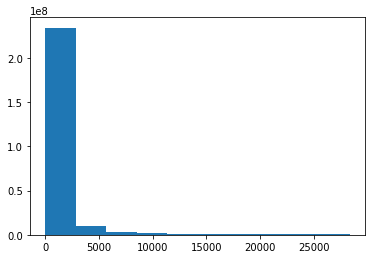

In [30]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=data.sleep_time_modified.quantile(q=0.99)])
plt.show()

Again we see that most of the observations have a very low sleep time so we again constrict the interval of intrest. 

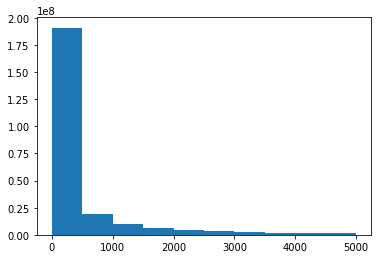

In [32]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=5000])
plt.show()

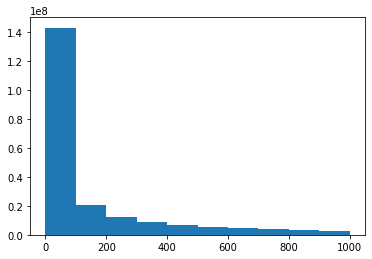

In [18]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=1000])
plt.show()

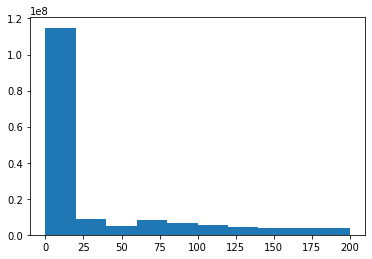

In [19]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=200])
plt.show()

# Opening the same data twice
Here we investigate the possiblity of opening the same data right after each other. As we are intrested in the patterns of usage it is not neccessarily of much intrest that you close an app and immediatly open it again to continue the same activity.

We start by the number of times the app which is opend is the same as the last one opened.

In [144]:
data["previous_app_code"]=user_groups.app_code.shift(1)

In [145]:
data.app_code[data.app_code==data.previous_app_code].count()

55448447

In [146]:
print("Procent of all apps which are opened directly after the same app: ",data.app_code[data.app_code==data.previous_app_code].count()/data.shape[0]*100)

Procent of all apps which are opened directly after the same app:  21.791454132467504


we now take all look at the sleeping times for these obervations

In [147]:
print("max sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].max())
print("min sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].min())

max sleep time:  6067204.0
min sleep time:  -23445.0


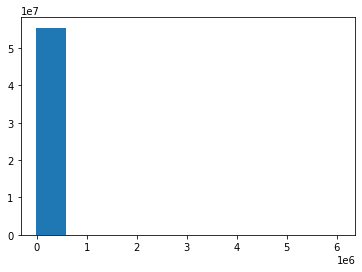

In [38]:
plt.hist(data.sleep_time[data.app_code==data.previous_app_code])
plt.show()

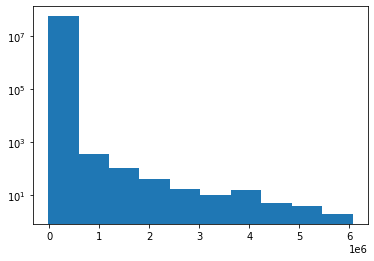

In [39]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code) ])
plt.yscale('log')
plt.show()

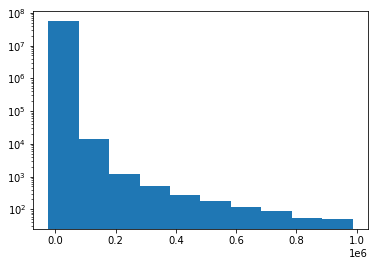

In [40]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<1000000)])
plt.yscale('log')
plt.show()

However we are esspecially interested in the ones used very close to each other.

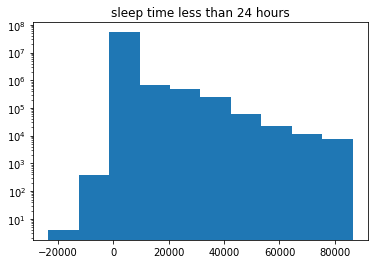

In [41]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)])
plt.yscale('log')
plt.title("sleep time less than 24 hours")
plt.show()

In [148]:
print("number of times the same app is opened while the app is in use: ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<0)].count())
print("number of times the same app is opened right after (sleep time 0): ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time==0)].count())

number of times the same app is opened while the app is in use:  4821
number of times the same app is opened right after (sleep time 0):  409933


We see that a small number is used at the same time. For our purpose it is clear that these should be combined. Also we see that approcimately 400000 are opened imediatly after with no sleep time in between. For these it is also clear that they can be combined.

Since we now filter out the apps which overlap in use time.

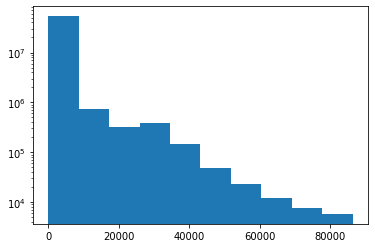

In [43]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)&(data.sleep_time>0)])
plt.yscale('log')
plt.show()

In [44]:
data.sleep_time[(data.app_code==data.previous_app_code)].mean()

1553.9468436329696

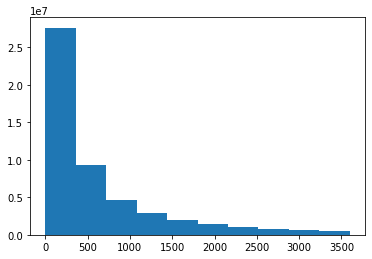

In [45]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60)&(data.sleep_time>0)])
plt.show()

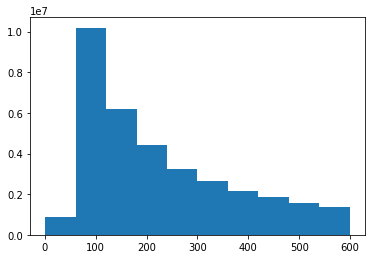

In [46]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<10*60)&(data.sleep_time>0)])
plt.show()

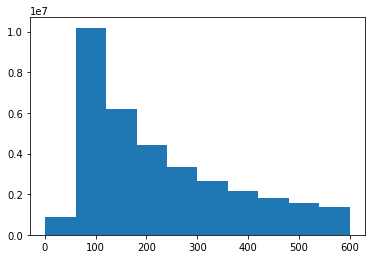

In [49]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)])
plt.show()

In [149]:
data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)].count()/data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)].count()

0.6278039527530889

Now we combine the observations where the same app is used again after a maximum of 10min sleep time.

In [50]:
data[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0
26,com.android.chrome,0,33229,33239,10,7649,460.0,460.0,7649.0
28,com.sonyericsson.album,0,33552,33562,10,45260,217.0,217.0,45260.0
46,com.sonyericsson.android.socialphonebook,0,48785,48795,10,45261,491.0,491.0,45261.0
...,...,...,...,...,...,...,...,...,...
254450388,com.whatsapp,9999,29163246,29163262,16,53003,217.0,217.0,53003.0
254450389,com.whatsapp,9999,29163490,29163500,10,53003,228.0,228.0,53003.0
254450399,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0
254450405,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0


## Combine observations

In [150]:
data2=data.copy()

For all app usages that should be merged together, the indexes of those with the highest end time.\
This mean that we are only interested in obervertions that need to be merged so the first step is to filter the data according to this criteria.

In [151]:
data2=data2[(data2.previous_app_code==data2.app_code) | (data2.app_code==data2.app_code.shift(-1))]

We now identify which belong to the same event. This is done in order to accomendate situation where the same app is used more than twice in a row. Here the critia is selected to be 10 min.\
Insperation for this part of the solution was found here: https://stackoverflow.com/questions/38885770/weather-events-grouped-based-on-time-differences-in-pandas (visited 24.9.2021)

In [152]:
data2['new_event'] = data2.groupby(['user_id','app_code']).sleep_time.apply(lambda s: s>60*10)

In [153]:
data2.loc[data2[data2.app_code!=data2.previous_app_code].index,'new_event'] = True

In [154]:
data2['event'] = data2.groupby(['user_id','app_code']).new_event.cumsum().astype('int')

In [155]:
data2[data2.package_name=="com.whatsapp"].iloc[0:30,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event
6,com.whatsapp,0,1712,1788,76,53003,0.0,0.0,23967.0,True,1
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0,False,1
8,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,True,2
13,com.whatsapp,0,4076,4156,80,53003,0.0,0.0,7649.0,True,3
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0,False,3
120,com.whatsapp,0,175736,175916,180,53003,0.0,0.0,7649.0,True,4
121,com.whatsapp,0,176086,176166,80,53003,170.0,170.0,53003.0,False,4
133,com.whatsapp,0,177236,177267,31,53003,-141.0,0.0,7649.0,True,5
134,com.whatsapp,0,177377,177567,190,53003,110.0,110.0,53003.0,False,5
136,com.whatsapp,0,178561,178581,20,53003,1044.0,1044.0,19968.0,True,6


We are now ready to identify the indexes of the highest end time for each event.\
Insperation for this part of the solution was found here: https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby (visited 24.9.2021)

In [156]:
data2[(data2.user_id==2607)&(data2.app_code==45261)&(data2.event==56)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event
66286712,com.sonyericsson.android.socialphonebook,2607,7010118,7010142,24,45261,640.0,640.0,40018.0,True,56


In [157]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

We now have the index of the end times for the ones that need to be combined,

In [158]:
max_index=data2.iloc[data3.index].index

We now need to find the index of the lowest start time within each of the events, that needs to be combined.

In [159]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

In [160]:
min_index=data2.iloc[data3.index].index

As a sanity check we count the number of combined events, the number of min indices and the number of max indices, as they all three should be the same.

In [161]:
print("number of combined events: ",data2.groupby(['user_id','app_code']).agg({"event": "nunique"}).event.sum())
print("number of found min indices: ",len(min_index))
print("number of found max indices: ",len(max_index))

number of combined events:  56474120
number of found min indices:  56474120
number of found max indices:  56474120


The observations can now be updated.

In [162]:
data3=data.copy()

In [163]:
data3.loc[min_index,"end_time"]=data3.loc[max_index].set_index(min_index).end_time

In [164]:
data3=data3.drop(set(data2.index)-set(min_index))

In [165]:
data3

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0
...,...,...,...,...,...,...,...,...,...
254450417,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0
254450418,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0
254450419,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0
254450420,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0


In [166]:
len(data.index)-(len(data2.index)-len(min_index))==len(data3.index)

True

Then the sleep time spend is updated, as well as the sleep time is updated and the previous app code

In [167]:
data3['time_spend']=data3['end_time']-data3['start_time']

In [168]:
user_groups=data3.groupby('user_id')

In [169]:
data3['sleep_time']=data3['end_time'].shift(1,fill_value=0.0)
data3['sleep_time']=data3.start_time-data3['sleep_time']

In [170]:
data3[data3.sleep_time<0].sleep_time_modified=0

/home/s164574/.conda/envs/myenv/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [171]:
data3['previous_app_code']=data3.app_code.shift(1)

now the index is reset

In [172]:
data3=data3.reset_index(drop=True)

In [173]:
data3.to_csv("sorted_coded_data_with_merged_events_10_min.csv",index=False)

In [174]:
data2[data2.sleep_time<=10*60].app_code.count()/data2.app_code.count()*100

69.43981404745647

We now look at the updated numbers for the same app used right after each.

In [175]:
print("Number of same number of apps after the same app: ",data3.app_code[data3.app_code==data3.previous_app_code].count())
print("Procent of apps which are the same as the previous: ",data3.app_code[data3.app_code==data3.previous_app_code].count()/len(data3.app_code)*100)

Number of same number of apps after the same app:  20483819
Procent of apps which are the same as the previous:  9.332661087851086


We see that now less a little over 9% of the the observations represent the same apps.

An alternative would be to use the 90-quantlie to select where we choose to split, because the 10 min still seem a little random.

# Use time of apps.
Part of the intrest in use times is that if we are intrested in understanding how we use apps, it can cloud the overall image to look at something which might be for instance is opened by mistake, here can the use times for instance be an indication if for instance an app is only opened for a second, then the user will not actualy interact with the app.

In [176]:
data=pd.read_csv("sorted_coded_data_with_merged_events_10_min.csv")

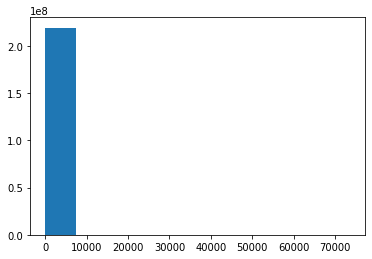

In [47]:
plt.hist(data.time_spend)
plt.show()

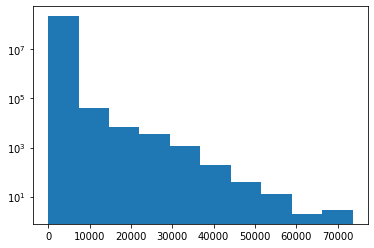

In [48]:
plt.hist(data.time_spend)
plt.yscale('log')
plt.show()

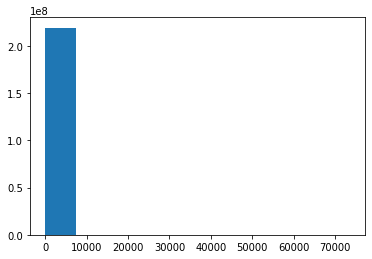

In [49]:
bins=plt.hist(data.time_spend)

In [50]:
bins

(array([2.19431821e+08, 4.15580000e+04, 7.01400000e+03, 3.50600000e+03,
        1.15500000e+03, 1.87000000e+02, 3.90000000e+01, 1.30000000e+01,
        2.00000000e+00, 3.00000000e+00]),
 array([1.00000e+00, 7.36170e+03, 1.47224e+04, 2.20831e+04, 2.94438e+04,
        3.68045e+04, 4.41652e+04, 5.15259e+04, 5.88866e+04, 6.62473e+04,
        7.36080e+04]),
 <BarContainer object of 10 artists>)

In [71]:
print("The 90-quantile of spend time: ",data.time_spend.quantile(q=0.90)/60," min.")

The 90-quantile of spend time:  8.85  min.


In [72]:
print("Shortest time spend in an app: ",data.time_spend.min()," sec.")
print("Longest time spend in an app: ",data.time_spend.max()/60/60, " hours.")


Shortest time spend in an app:  1  sec.
Longest time spend in an app:  20.446666666666665  hours.


We see that the lowest number of use times is 1 second, and that most of the use times are in the interval between 1 sec. to 7361.70 sec (which coresponds to approximately 2 hours and 5 min.). Below we also see that 90 procent of the observations are below 8.85 min, indicating that while the there is a large rande in the times spend in apps, the fast majority is only used for short period of times. This also mean that we need to look closer at the lower range to see the effect of evaluating potential apps used by mistake/no interaction.

In [75]:
print("procent of observations where a app is used a minute or less: ", data[data.time_spend<=60].app_code.count()/data.shape[0]*100)

procent of observations where a app is used a minute or less:  51.546304026249636


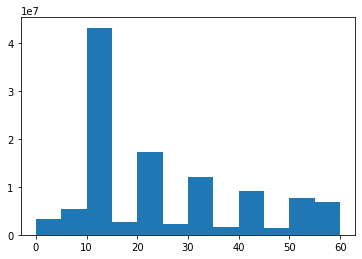

In [77]:
plt.hist(data[data.time_spend<=60].time_spend,bins=[0, 5, 10, 15, 20, 25, 30,35,40,45,50,55,60])
plt.show()

It is clear than most of the app uses for a minute or less, is used for 10 to 15 seconds. Based on this it does not make a lot of sense to exclude observation within this interval or higher. As it indicates a pretty common use pattern.

In [78]:
print("procent of observations where a app is used less than 10 seconds: ", data[data.time_spend<10].app_code.count()/data.shape[0]*100)

procent of observations where a app is used less than 10 seconds:  3.9630563319097574


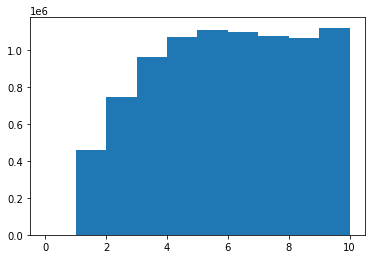

In [79]:
plt.hist(data[data.time_spend<10].time_spend,bins=[0, 1, 2, 3, 4, 5, 6,7,8,9,10])
plt.show()

maybe the ones that are opend for only one second or one to two secons are worth removing but it is kinda hard to tell.

In [84]:
print("numer of different apps used for less than 2 seconds :",data[data.time_spend<2].app_code.nunique())
print("numer of different apps used for less than 3 seconds :",data[data.time_spend<3].app_code.nunique())

numer of different apps used for less than 2 seconds : 5910
numer of different apps used for less than 3 seconds : 8545


Checking if certian apps dominate

In [91]:
data[data.time_spend<2].groupby('app_code').user_id.count().max()/data[data.time_spend<2].shape[0]*100

15.264125885734755

In [93]:
data[data.time_spend<3].groupby('app_code').user_id.count().max()/data[data.time_spend<3].shape[0]*100

13.409546707470682

In [94]:
data[data.time_spend<2].groupby('app_code').user_id.count().max()

69881

In [95]:
data[data.time_spend<2].app_code.value_counts()[:10].index.tolist()

[23949, 53003, 19968, 45264, 19973, 7655, 23906, 7649, 45329, 23947]

In [98]:
data[data.app_code==23949]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
58,com.google.android.googlequicksearchbox,0,67574,67584,10,23949,-6340.0,6340.0,7649.0
963,com.google.android.googlequicksearchbox,0,1611141,1611151,10,23949,978.0,0.0,23967.0
1075,com.google.android.googlequicksearchbox,0,1839621,1839631,10,23949,40.0,0.0,19968.0
1644,com.google.android.googlequicksearchbox,0,2794866,2794876,10,23949,-31741.0,31741.0,44582.0
4739,com.google.android.googlequicksearchbox,0,10173976,10174016,40,23949,-271.0,271.0,45264.0
...,...,...,...,...,...,...,...,...,...
219485231,com.google.android.googlequicksearchbox,9999,29129783,29129853,70,23949,0.0,0.0,45264.0
219485250,com.google.android.googlequicksearchbox,9999,29146727,29146737,10,23949,-1542.0,1542.0,53003.0
219485253,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,111.0,0.0,44880.0
219485293,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,-185.0,185.0,19968.0


In [109]:
data[data.time_spend<2].package_name.value_counts().sort_values(ascending=False)[:10]/data[data.time_spend<2].shape[0]*100

com.google.android.googlequicksearchbox    15.264126
com.whatsapp                                8.186985
com.facebook.katana                         6.310451
com.sonyericsson.conversations              5.560143
com.facebook.orca                           4.811582
com.android.phone                           3.990066
com.google.android.apps.maps                3.750448
com.android.chrome                          3.641451
com.sonymobile.email                        3.071566
com.google.android.gm                       3.055184
Name: package_name, dtype: float64

In [112]:
data[data.time_spend<=10].package_name.value_counts().sort_values(ascending=False)[:10]/data[data.time_spend<=10].shape[0]*100

com.whatsapp                                9.648410
com.google.android.googlequicksearchbox     9.252028
com.facebook.katana                         7.470179
com.facebook.orca                           7.001800
com.sonyericsson.conversations              6.608131
com.android.chrome                          4.894364
com.google.android.gm                       4.005481
com.sonymobile.email                        3.959347
com.sonyericsson.android.socialphonebook    3.369362
com.instagram.android                       3.017417
Name: package_name, dtype: float64

# Updated sleep distribution

In [177]:
data[data.sleep_time<0].shape[0]/data.shape[0]*100

8.251323512338399

In [119]:
data

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0
3,com.facebook.katana,0,1042,1502,460,19968,-10.0,10.0,23916.0
4,com.whatsapp,0,1512,1572,60,53003,-10.0,10.0,19968.0
...,...,...,...,...,...,...,...,...,...
219485293,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,-185.0,185.0,19968.0
219485294,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0
219485295,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0
219485296,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,-5890.0,5890.0,23875.0


In [183]:
18103959/254450411*100

7.114926216409216

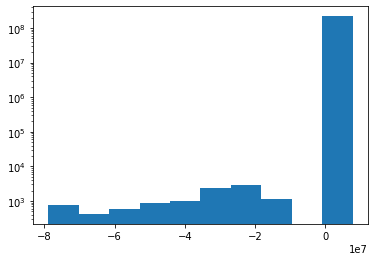

In [187]:
plt.hist(data.sleep_time)
plt.yscale('log')
plt.show()

we see that most of the data is closer toa positive sleep time.

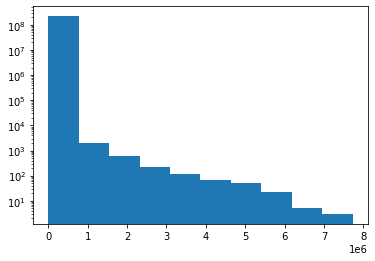

In [193]:
plt.hist(data.sleep_time_modified)
plt.yscale('log')
plt.show()

43.833333333333336


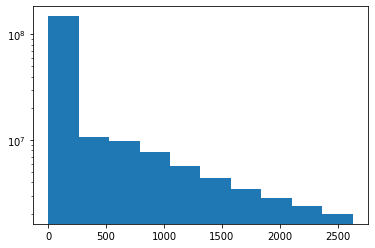

In [198]:
print(data.sleep_time_modified.quantile(0.9)/60)
plt.hist(data[data.sleep_time_modified<=data.sleep_time_modified.quantile(0.9)].sleep_time_modified)
plt.yscale('log')
plt.show()

(array([2.0137177e+08, 1.9820000e+03, 6.2100000e+02, 2.2500000e+02,
        1.1300000e+02, 6.5000000e+01, 5.0000000e+01, 2.2000000e+01,
        5.0000000e+00, 3.0000000e+00]),
 array([      0. ,  772826.2, 1545652.4, 2318478.6, 3091304.8, 3864131. ,
        4636957.2, 5409783.4, 6182609.6, 6955435.8, 7728262. ]),
 <BarContainer object of 10 artists>)

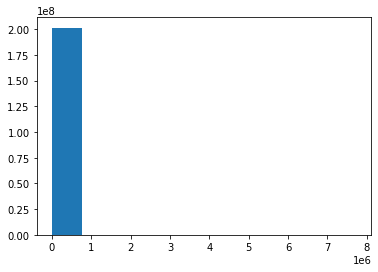

In [204]:
plt.hist(data[data.sleep_time>=0].sleep_time)


In [202]:
772826.2/60/60/24

8.944747685185185

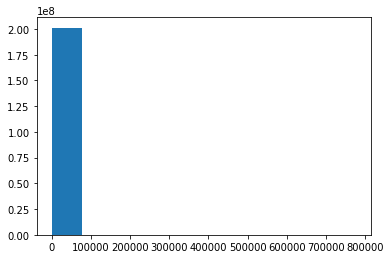

In [206]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=9*24*60*60)].sleep_time)
plt.show()

In [207]:
bins

(array([2.01275984e+08, 7.50030000e+04, 1.01240000e+04, 3.98500000e+03,
        2.33900000e+03, 1.43900000e+03, 1.10400000e+03, 8.02000000e+02,
        5.69000000e+02, 4.55000000e+02]),
 array([     0. ,  77750.6, 155501.2, 233251.8, 311002.4, 388753. ,
        466503.6, 544254.2, 622004.8, 699755.4, 777506. ]),
 <BarContainer object of 10 artists>)

In [208]:
77750.6/60/60

21.59738888888889

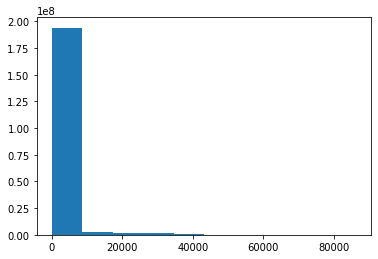

In [209]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=24*60*60)].sleep_time)
plt.show()

In [210]:
bins

(array([1.9398463e+08, 2.9998370e+06, 1.3262150e+06, 1.7349760e+06,
        7.2456800e+05, 2.6625000e+05, 1.2677100e+05, 6.9032000e+04,
        4.3735000e+04, 3.1176000e+04]),
 array([    0.,  8640., 17280., 25920., 34560., 43200., 51840., 60480.,
        69120., 77760., 86400.]),
 <BarContainer object of 10 artists>)

In [220]:
8640/60/60

2.4

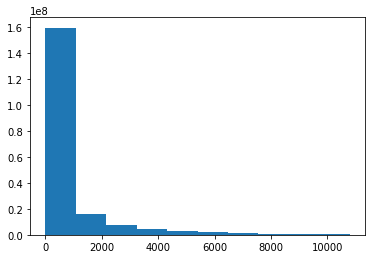

In [221]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=3*60*60)].sleep_time)
plt.show()

In [222]:
bins

(array([1.5931080e+08, 1.6277925e+07, 7.4548630e+06, 4.2340650e+06,
        2.6552900e+06, 1.8027580e+06, 1.2978470e+06, 9.5108200e+05,
        7.1620600e+05, 5.5362300e+05]),
 array([    0.,  1080.,  2160.,  3240.,  4320.,  5400.,  6480.,  7560.,
         8640.,  9720., 10800.]),
 <BarContainer object of 10 artists>)

In [225]:
3240/60

54.0

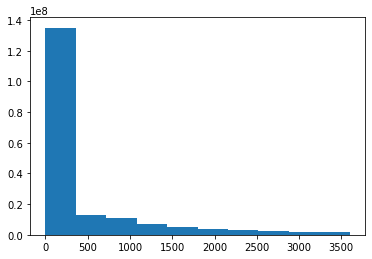

In [226]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=60*60)].sleep_time)
plt.show()

In [227]:
bins

(array([1.35080659e+08, 1.32202700e+07, 1.10098710e+07, 7.22456100e+06,
        5.17015600e+06, 3.88320800e+06, 3.03832100e+06, 2.42951600e+06,
        1.98702600e+06, 1.66356100e+06]),
 array([   0.,  360.,  720., 1080., 1440., 1800., 2160., 2520., 2880.,
        3240., 3600.]),
 <BarContainer object of 10 artists>)

In [229]:
720/60

12.0

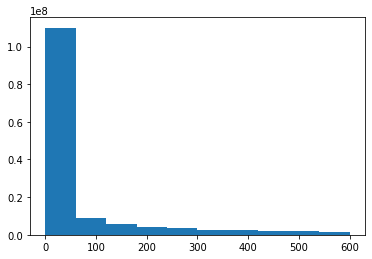

In [230]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=10*60)].sleep_time)
plt.show()

In [231]:
bins

(array([1.09981348e+08, 8.98418700e+06, 5.68302700e+06, 4.24434000e+06,
        3.38562100e+06, 2.80213600e+06, 2.39551100e+06, 2.09455800e+06,
        1.85980400e+06, 1.70534700e+06]),
 array([  0.,  60., 120., 180., 240., 300., 360., 420., 480., 540., 600.]),
 <BarContainer object of 10 artists>)

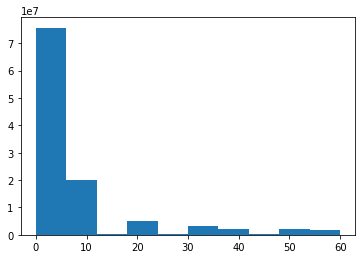

In [232]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=60)].sleep_time)
plt.show()

# Number of sequences vs. sleeptime thressholds.
From the above distributions we see that most sleep times are very low. which mean that we can start the experiement with a relativly low threshold. Start with 1 min, and the avg. sequence length/ number of sequences which are of length 1...

In [233]:
print(data.sleep_time.quantile(0.9)/60)

43.833333333333336
